In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, mpld3

from matplotlib.backends.backend_agg import FigureCanvasAgg
from django.http import HttpResponse

from alpha_vantage.timeseries import TimeSeries

ts = TimeSeries(key="3P9NBZQR6NNO2VEF")
portfolio = {
    "tickers": ["MSFT", "AAPL"]
}

###############
# Static Test #
###############

# data, _ = ts.get_daily_adjusted("MSFT")
# price_ticker = data['2021-12-01']['5. adjusted close']
# print(f'MSFT: {price_ticker}')

#####################
# TEST API: 1 stock #
#####################

# Function Test
# def last_price_data(ticker):
#     ts = TimeSeries(key="3P9NBZQR6NNO2VEF")
#     data, _ = ts.get_daily_adjusted(ticker)
    
#     price_ticker = data['2021-12-01']['5. adjusted close']
#     message = f'{ticker}: {price_ticker}'
    
#     return message

# print(last_price_data("MSFT"))

In [2]:
""" API: Returns a dictionary of tickers and historical prices """
def get_hist_prices(tickers):
    stocks_hist_prices = {}

    for ticker in tickers: 
        data, _ = ts.get_daily_adjusted(ticker, 'full')
        price_array = data
        stocks_hist_prices[ticker] = price_array

        # Log progress
        print(f'{ticker}: {data["2021-12-01"]["5. adjusted close"]}')
    
    return stocks_hist_prices

In [ ]:
get_hist_prices(portfolio["tickers"])

In [4]:
""" Processing: Returns df of stock daily returns (% change) """
def get_stock_daily_returns(tickers):
    data_frames = []

    stocks_hist_prices = get_hist_prices(tickers)

    # Generate array of dataframes
    for stock in stocks_hist_prices:

        df = pd.DataFrame.from_dict(stocks_hist_prices[stock], orient='index')

        # Post-Processing: Table: ticker | adj_close, Data Limit: 1 year
        df = df[:250]
        df['ticker'] = stock
        df = df[['ticker','5. adjusted close']]

        df.rename(columns={'5. adjusted close': 'adj_close'}, inplace=True, errors='raise')
        df['adj_close'] = df['adj_close'].astype('float64')

        data_frames.append(df)

    # Merge DF
    df_merged = pd.concat(data_frames)
    df_merged.reset_index(inplace=True)
    df_merged.rename(columns= {"index": "date"}, inplace=True, errors='raise')

    # Generate daily returns (% Change)
    df_pivot = df_merged.pivot(index='date', columns='ticker')
    returns_daily = df_pivot.pct_change()

    # print(returns_daily.head())

    return returns_daily

In [ ]:
get_stock_daily_returns(portfolio["tickers"])
# get_stock_daily_returns(portfolio["tickers"]).mean()*250

In [ ]:
""" Simulation: Returns a table with rows for returns, volatility, weights, sharpe ratio """
def get_simulation(tickers):
    returns_daily = get_stock_daily_returns(tickers)
    returns_annual = returns_daily.mean() * 250

    # Config simulation
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 250

    port_returns = []
    port_volatility = []
    stock_weights = []

    num_assets = len(portfolio["tickers"])
    num_portfolios = 1000

    # Run simulation
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        returns = np.sum(weights * returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))

        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio_stats = {'Returns': port_returns,
             'Volatility': port_volatility}

    for counter,symbol in enumerate(portfolio["tickers"]):
        portfolio_stats[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

    # Summary Table: get better labels for desired arrangement of columns
    df = pd.DataFrame(portfolio_stats)
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in portfolio["tickers"]]
    df = df[column_order]

    df['sharpe_ratio'] = df['Returns']/df['Volatility']
    max_index = df['sharpe_ratio'].idxmax()
    max_row = df.iloc[max_index]

    return max_row

In [35]:
get_simulation(portfolio["tickers"])

MSFT: 330.08
AAPL: 164.77


Returns         0.462424
Volatility      0.201017
MSFT Weight     0.000035
AAPL Weight     0.999965
sharpe_ratio    2.300426
Name: 19900, dtype: float64

In [18]:
""" Simulation Plot: Returns a plot """
def get_simulation_image(tickers):
    returns_daily = get_stock_daily_returns(tickers)
    returns_annual = returns_daily.mean() * 250

    # Config simulation
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 250

    port_returns = []
    port_volatility = []
    stock_weights = []

    num_assets = len(portfolio["tickers"])
    num_portfolios = 50000

    # Run simulation
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        returns = np.sum(weights * returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))

        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio_stats = {'Returns': port_returns,
             'Volatility': port_volatility}

    for counter,symbol in enumerate(portfolio["tickers"]):
        portfolio_stats[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

    # Summary Table: get better labels for desired arrangement of columns
    df = pd.DataFrame(portfolio_stats)
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in portfolio["tickers"]]
    df = df[column_order]

    # Config.: Create new figure and use Seaborn style
    fig = plt.figure()
    plt.style.use('seaborn')

    # Plot using df
    df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)

    # Find Max Sharpe and mark it on the plot
    returns = np.array(port_returns)
    risk = np.array(port_volatility)
    max_idx = np.where(returns / risk == np.max(returns / risk))[0][0]
    plt.plot(port_volatility[max_idx], port_returns[max_idx], 'o', color='C2')

    # Add labels
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier')
    # plt.show()

    # Generate response:
    # StackOverflow (V1): https://stackoverflow.com/questions/40534715/how-to-embed-matplotlib-graph-in-django-webpage
    # StackOverflow (V2): https://stackoverflow.com/questions/55216855/getting-attribute-error-module-matplotlib-pyplot-has-no-attribute-canvas?newreg=c1544c5c67514d43950a3ca996cad9d1

    html_fig = mpld3.fig_to_html(fig)
    response = HttpResponse(html_fig)

    return response


MSFT: 330.08
AAPL: 164.77


AttributeError: module 'matplotlib.pyplot' has no attribute 'canvas'

<Figure size 576x396 with 0 Axes>

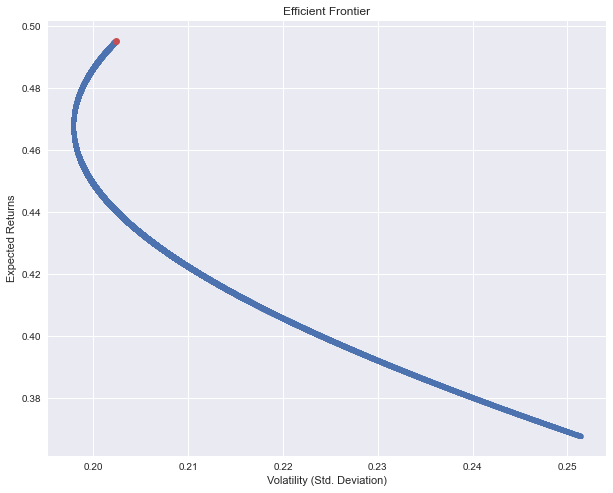

In [19]:
get_simulation_image(portfolio["tickers"])